In [1]:
from models import vae_HYP, vae_HYP_1, vae_EUCL1
import geoopt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from hypmath import poincareball
from hypmath import metrics
import pandas as pd 
from tqdm import tqdm
import time

In [2]:

transform = transforms.Compose([
        transforms.ToTensor(),
        ])

trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET',
                               download=True, train=True, transform=transform)
testset = datasets.MNIST('PATH_TO_STORE_TESTSET',
                            download=True, train=False, transform=transform)

size = len(trainset)
# print(size)

#Splitting training set into training and validation data
train_data, val_data = torch.utils.data.random_split(trainset, [int(size-size*0.2), int(size*0.2)])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True, num_workers=6, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=256, num_workers=6, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True, num_workers=6, pin_memory=True)


C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
model = vae_EUCL1.VariationalAutoencoder(latent_dims=4)

In [4]:
learning_rate = 1e-3

In [5]:
optim = geoopt.optim.RiemannianAdam(model.parameters(), lr=learning_rate)
#optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
### Training function
def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        # x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        #ball = poincareball.PoincareBall()
        loss = ((x - x_hat)**2).sum() + (vae.encoder.kl)

        # Backward pass
        #optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None
            
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [7]:
### Testing function
def test_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            # x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [8]:
def plot_ae_outputs(encoder,decoder,n):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = testset[i][0].unsqueeze(0)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 45158.144531
	 partial train loss (single batch): 44023.953125
	 partial train loss (single batch): 42927.742188
	 partial train loss (single batch): 42034.101562
	 partial train loss (single batch): 41281.277344
	 partial train loss (single batch): 40760.375000
	 partial train loss (single batch): 39868.710938
	 partial train loss (single batch): 39410.265625
	 partial train loss (single batch): 38902.492188
	 partial train loss (single batch): 38451.695312
	 partial train loss (single batch): 38107.355469
	 partial train loss (single batch): 37632.421875
	 partial train loss (single batch): 37263.593750
	 partial train loss (single batch): 37002.703125
	 partial train loss (single batch): 36593.792969
	 partial train loss (single batch): 36432.375000
	 partial train loss (single batch): 36060.851562
	 partial train loss (single batch): 35939.953125
	 partial train loss (single batch): 35596.031250
	 partial train loss (single batch): 35347.585938


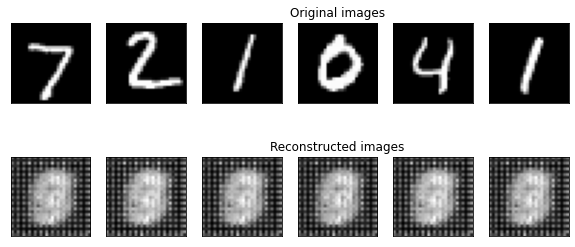

	 partial train loss (single batch): 17755.460938
	 partial train loss (single batch): 17483.550781
	 partial train loss (single batch): 17777.230469
	 partial train loss (single batch): 17820.287109
	 partial train loss (single batch): 17898.919922
	 partial train loss (single batch): 17515.642578
	 partial train loss (single batch): 17403.865234
	 partial train loss (single batch): 17281.755859
	 partial train loss (single batch): 17680.767578
	 partial train loss (single batch): 17361.902344
	 partial train loss (single batch): 17565.232422
	 partial train loss (single batch): 17152.845703
	 partial train loss (single batch): 17349.140625
	 partial train loss (single batch): 17206.316406
	 partial train loss (single batch): 16999.179688
	 partial train loss (single batch): 17113.982422
	 partial train loss (single batch): 17199.625000
	 partial train loss (single batch): 17293.644531
	 partial train loss (single batch): 17122.691406
	 partial train loss (single batch): 17069.439453


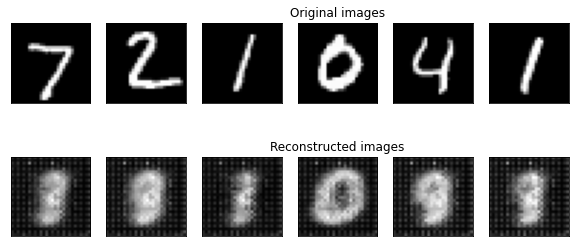

	 partial train loss (single batch): 13822.111328
	 partial train loss (single batch): 14044.418945
	 partial train loss (single batch): 13941.654297
	 partial train loss (single batch): 13742.924805
	 partial train loss (single batch): 13526.038086
	 partial train loss (single batch): 13687.628906
	 partial train loss (single batch): 13456.186523
	 partial train loss (single batch): 13480.981445
	 partial train loss (single batch): 13649.856445
	 partial train loss (single batch): 13600.274414
	 partial train loss (single batch): 13465.176758
	 partial train loss (single batch): 13531.933594
	 partial train loss (single batch): 13860.592773
	 partial train loss (single batch): 13656.126953
	 partial train loss (single batch): 13526.772461
	 partial train loss (single batch): 13385.455078
	 partial train loss (single batch): 13306.271484
	 partial train loss (single batch): 13397.309570
	 partial train loss (single batch): 13440.065430
	 partial train loss (single batch): 13543.745117


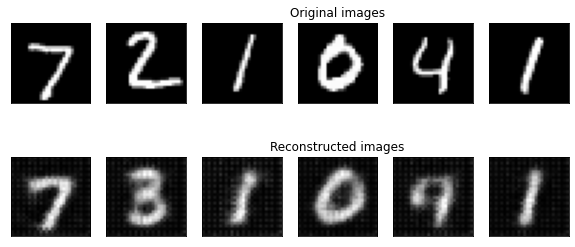

	 partial train loss (single batch): 10829.480469
	 partial train loss (single batch): 10972.351562
	 partial train loss (single batch): 10801.295898
	 partial train loss (single batch): 10764.886719
	 partial train loss (single batch): 10702.333008
	 partial train loss (single batch): 10478.233398
	 partial train loss (single batch): 10641.381836
	 partial train loss (single batch): 11023.031250
	 partial train loss (single batch): 10734.628906
	 partial train loss (single batch): 10497.705078
	 partial train loss (single batch): 10528.966797
	 partial train loss (single batch): 10734.357422
	 partial train loss (single batch): 10838.746094
	 partial train loss (single batch): 10591.703125
	 partial train loss (single batch): 10759.016602
	 partial train loss (single batch): 10656.465820
	 partial train loss (single batch): 10932.134766
	 partial train loss (single batch): 10439.140625
	 partial train loss (single batch): 10649.932617
	 partial train loss (single batch): 10622.756836


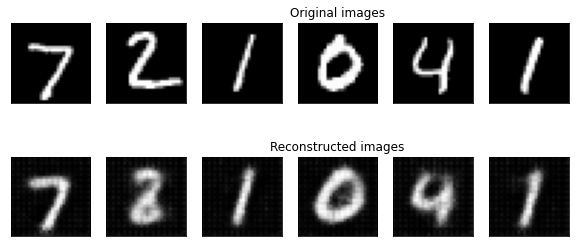

	 partial train loss (single batch): 9666.125977
	 partial train loss (single batch): 9821.256836
	 partial train loss (single batch): 9635.380859
	 partial train loss (single batch): 9940.541992
	 partial train loss (single batch): 9754.140625
	 partial train loss (single batch): 9921.554688
	 partial train loss (single batch): 9763.380859
	 partial train loss (single batch): 9806.394531
	 partial train loss (single batch): 10017.176758
	 partial train loss (single batch): 9896.306641
	 partial train loss (single batch): 9795.671875
	 partial train loss (single batch): 9753.494141
	 partial train loss (single batch): 9906.803711
	 partial train loss (single batch): 9811.818359
	 partial train loss (single batch): 9778.800781
	 partial train loss (single batch): 10031.594727
	 partial train loss (single batch): 9787.282227
	 partial train loss (single batch): 9479.801758
	 partial train loss (single batch): 9821.884766
	 partial train loss (single batch): 9792.877930
	 partial train lo

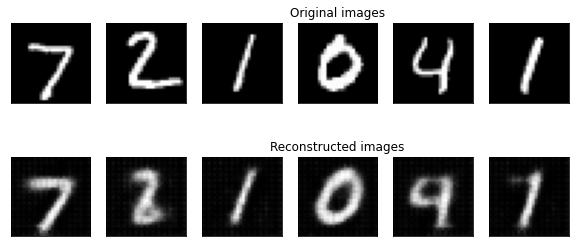

In [9]:
num_epochs = 10

for epoch in range(num_epochs):
   train_loss = train_epoch(model, trainloader,optim)
   val_loss = test_epoch(model, valloader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(model.encoder, model.decoder,n=6)




In [10]:
encoded_samples = []
for sample in tqdm(testset):
    img = sample[0].unsqueeze(0)
    label = sample[1]
    # Encode image
    model.eval()
    with torch.no_grad():
        encoded_img  = model.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)



from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
import plotly.express as px

#Davies-Bouldin Index
db_index = davies_bouldin_score(encoded_samples, encoded_samples.label)
print(db_index)

#Calinski-Harabasz Index
ch_score = calinski_harabasz_score(encoded_samples, encoded_samples.label)
print(ch_score)

#Silhouette Coefficient
s_coeff = silhouette_score(encoded_samples, encoded_samples.label,  metric=metrics.PoincareDistance)
print(s_coeff)

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

100%|██████████| 10000/10000 [00:06<00:00, 1439.77it/s]


1.1147139549309848
10004.427458062455


KeyboardInterrupt: 

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})

# #Davies-Bouldin Index
# db_index = davies_bouldin_score(tsne_results, encoded_samples.label)
# print(db_index)

# #Calinski-Harabasz Index
# ch_score = calinski_harabasz_score(tsne_results, encoded_samples.label)
# print(ch_score)

# #Silhouette Coefficient
# s_coeff = silhouette_score(tsne_results, encoded_samples.label)
# print(s_coeff)
fig.show()